----

# Artificial Neural Network for Approximating  
# the Theoretical Value of Financial Options  
# Gradient‐Descent Method


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import gamma
from timeit import default_timer as timer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from warnings import filterwarnings
filterwarnings('ignore') 

## Data Generation – Theoretical BSM Option Prices


In [2]:
# BSM Model for Option Pricing
# Black-Scholes-Merton (BSM) model for option pricing
# This function calculates the theoretical price of a European call or put option
# using the Black-Scholes-Merton formula.
# Parameters:
# S: Current price of the underlying asset
# K: Strike price of the option
# T: Time to expiration (in years)
# r: Risk-free interest rate (annualized)
# sigma: Volatility of the underlying asset (annualized)
# opcion: Type of option ('call' or 'put')
# Returns:
# The theoretical price of the option based on the BSM model.
# The function uses the cumulative distribution function (CDF) of the standard normal distribution
# to calculate the probabilities associated with the option's payoff at expiration.
# The BSM formula is derived from the Black-Scholes differential equation and assumes that the underlying
# asset follows a geometric Brownian motion with constant volatility and interest rate.
# The function returns the price of the option based on the specified type (call or put).
# The BSM model is widely used in finance for pricing European options and is a fundamental concept
# in financial mathematics. It provides a theoretical framework for understanding how options are priced
# based on the underlying asset's price, strike price, time to expiration, risk-free interest     

def BSM_option_price(S, K, T, r, sigma, option = 'call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / \
    (sigma * np.sqrt(T)) 
    d2 = (np.log(S / K) + (r - 0.5 * sigma**2) * T) / \
    (sigma * np.sqrt(T))
    if option == 'call':
        precio = (S * norm.cdf(d1) - K * np.exp(-r * T) * \
                  norm.cdf(d2))
    if option == 'put':
        precio = (K * np.exp(-r * T) * norm.cdf(-d2) - S * \
                  norm.cdf(-d1))  
    return precio

## Creation of DataFrame with Options Data


In [3]:
# List of Variables for the BSM Model
# L: Number of samples
# S: Current price of the underlying asset
# K: Strike price of the option
# T: Time to expiration (in years) 
# r: Risk-free interest rate (annualized)
# sigma: Volatility of the underlying asset (annualized)

L = 10000
S = np.linspace(80, 120, L)
K =  np.repeat(100, L)
T = np.repeat(0.25, L)
r = np.repeat(0.05, L)
sigma = np.repeat(0.3, L)

In [4]:
# Call Option Prices Calculation
# This code calculates the theoretical price of a European call option

C = [BSM_option_price(S[i], K[i], T[i], r[i], sigma[i],\
                       option = 'call') for i in range(L)]
print(C[:2])

[np.float64(0.48332457542773977), np.float64(0.4836922265470971)]


In [5]:
# Creation of DataFrame with Options Data
# This code creates a DataFrame containing the option data, including the underlying asset's price,
# strike price, time to expiration, risk-free interest rate, volatility, and the calculated option
# price. The DataFrame is structured to facilitate further analysis or modeling of the option pricing data

values = np.array([S, K, T, r, sigma, C])
values = values.T
columnas = ['S', 'K', 'T', 'r', 'sigma', 'C']
data = pd.DataFrame(data = values,  columns = columnas) 
data.head()

,S,K,T,r,sigma,C
0,80.000000,100.0,0.25,0.05,0.3,0.483325
1,80.004000,100.0,0.25,0.05,0.3,0.483692
2,80.008001,100.0,0.25,0.05,0.3,0.484060
3,80.012001,100.0,0.25,0.05,0.3,0.484428
4,80.016002,100.0,0.25,0.05,0.3,0.484797


In [6]:
# Create numpy arrays for features and target variable
# This code extracts the features (S, K, T, r, sigma) and the target variable (C) from the DataFrame
# and converts them into numpy arrays for further processing
# The features represent the input variables for the model, while the target variable represents
# the output variable that the model aims to predict. This structure is commonly used in machine learning
# and data analysis tasks where the goal is to learn a mapping from input features to output targets
# The features are the independent variables that influence the option price, while the target variable
# is the dependent variable that we want to predict or analyze. This separation allows for easier manipulation
# and analysis of the data, especially when applying machine learning algorithms or statistical models.

y = np.array(data[['C']])
X = np.array(data[['S', 'K', 'r','sigma','T']])

## Data Transformation  
### We transform the data to scale it using MinMaxScaler function


In [7]:
# MinMax transformation of data
# We transform the data to scale it using MinMaxScaler function
# This transformation scales the features and target variable to a range between 0 and 1,                               
# which is useful for many machine learning algorithms that perform better with normalized data.

scalerX = MinMaxScaler()
scalerX.fit(X)
X = scalerX.transform(X)
scalerY = MinMaxScaler()
scalerY.fit(y)
y = scalerY.transform(y)

-----

## Artificial Neural Network


In [8]:
# Activation Functions Class 
# This class contains various activation functions and their derivatives, including ReLU, ELU, and
# their fractional derivatives using the Caputo definition. 

class Activation_Functions:

    #ReLU activation function
    @staticmethod
    def relu(x):
        return np.maximum(0, x)

    @staticmethod
    def relu_derivative(x):
        return np.where(x > 0, 1, 0)

 
##################################################################################


# Gradient Descent Class
# This class implements the gradient descent optimization algorithm for updating the weights and biases
# of a neural network layer. It uses a specified learning rate to adjust the weights and biases
# based on the gradients computed during backpropagation. The update_weights method applies the gradient
# descent step to the layer's weights and biases, allowing the model to learn from the data
# and improve its predictions over time. The learning rate controls the size of the step taken in
# the direction of the gradient, influencing the convergence speed and stability of the training process.       

class Gradient_Descent:
    def __init__(self, learning_rate=0.001):
        self.learning_rate = learning_rate

    def update_weights(self, layer):
        layer.weights -= self.learning_rate * layer.dweights 
        layer.biases -= self.learning_rate * layer.dbiases   
        

# Backpropagation Class
# This class implements the backpropagation algorithm for training neural networks.
# It calculates the gradients of the loss function with respect to the model's predictions
# and propagates these gradients backward through the network layers to update the weights and biases.
# The backward method takes the predicted values, true values, and the layers of the network as inputs.
# It computes the initial gradients using the specified loss function and then iterates through
# the layers in reverse order, calling the backward method of each layer to compute the gradients.
# The gradients are then used to update the weights and biases of each layer.
class Backpropagation:
    def __init__(self, loss_function):
        self.loss_function = loss_function

    def backward(self, y_pred, y_true, layers):
        dvalues = self.loss_function.derivative(y_pred, y_true)
        for layer in reversed(layers):
            layer.backward(dvalues)
            dvalues = layer.dinputs


# Mean Squared Error Loss Class
# This class implements the Mean Squared Error (MSE) loss function.
class Loss_MeanSquaredError:
    def calculate(self, y_pred, y_true):
        return np.mean((y_true - y_pred) ** 2)

    def derivative(self, y_pred, y_true):
        return 2 * (y_pred - y_true) / y_true.shape[0] 

# Layer_Dense Class
# This class represents a dense layer in a neural network. It initializes the weights and biases,
# performs the forward pass by calculating the output of the layer, and computes the gradients during
# the backward pass. The weights are initialized using a random normal distribution scaled by 0.1,
# and the biases are initialized to a small constant value (0.01). The forward method computes the output of the layer
# by performing a dot product between the inputs and the weights, followed by adding the biases.
# The backward method calculates the gradients of the weights, biases,
# and inputs based on the gradients of the output (dvalues) received from the next layer
# during backpropagation. The gradients are computed using the chain rule, allowing the model to
# learn from the errors in the predictions and adjust the weights and biases accordingly.
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons, seed):
        np.random.seed(seed)
        self.weights = 0.1 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.ones((1, n_neurons))*0.01

    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)

## Variables and Hyperparameters for the Neural Network


In [9]:
# Random seed
seed=7
# Learning rate
l_rate = 0.17 
# Maximum number of iterations for training the neural network
epochs=5000
# Tolerance 
tolerance = 1e-4

## Architecture and Training of the Artificial Neural Network


In [10]:
# Initialize Layers
dense1 = Layer_Dense(5, 32, seed)
dense2 = Layer_Dense(32, 32, seed)
dense3 = Layer_Dense(32, 32, seed)
dense4 = Layer_Dense(32, 1, seed)

# Initialize Activation Functions
activation_funcs = Activation_Functions()
# Initialize Loss Function
loss_function = Loss_MeanSquaredError()
# Initialize Gradient Descent
gd_optimizer = Gradient_Descent(learning_rate=l_rate)
# Initialize Backpropagation
backprop = Backpropagation(loss_function)


# Training Loop 
# This loop iterates through the specified number of epochs, performing forward and backward passes
# through the neural network layers, calculating the loss, and updating the weights and biases using
# gradient descent. The loss is calculated using the mean squared error function, and the gradients 
# are computed using the chain rule. The weights and biases are updated based on the gradients
# to minimize the loss function. The loop also keeps track of the lowest loss encountered during training
# and updates the weights and biases accordingly. If the loss falls below a specified tolerance,
# the training process is terminated early to prevent overfitting and unnecessary computations.

# Initialize variables
lowest_loss = float('inf')
loss_list = []
N=0

# Start training time count 
from timeit import default_timer as timer
start = timer()


# Training loop
for iteration in range(epochs):
   
    #########################################################################################################################
   
    # Forward pass

    #ReLU
    dense1.forward(X)
    activation1_output = activation_funcs.relu(dense1.output)
    dense2.forward(activation1_output)
    activation2_output = activation_funcs.relu(dense2.output)
    dense3.forward(activation2_output)
    activation3_output = activation_funcs.relu(dense3.output)
    dense4.forward(activation3_output)
    y_pred = dense4.output

    # Calculate Loss Function
    loss = loss_function.calculate(y_pred, y)

    # Create a list of loss values
    loss_list.append(loss)


    #########################################################################################################################
    
    # Backward pass
    
    # Loss Funtion Gradient
    dvalues = loss_function.derivative(y_pred, y) 
    dense4.backward(dvalues)

    # ReLU Activation Function Gradient Descent
    dvalues = dense4.dinputs * activation_funcs.relu_derivative(dense3.output)
    dense3.backward(dvalues)
    dvalues = dense3.dinputs * activation_funcs.relu_derivative(dense2.output)
    dense2.backward(dvalues)
    dvalues = dense2.dinputs * activation_funcs.relu_derivative(dense1.output)
    dense1.backward(dvalues)


# #########################################################################################################################
    
    # Update Weights and Biases
    # This section updates the weights and biases of each layer using the gradient descent optimizer.
    # The update_weights method of the Gradient_Descent class is called for each layer,
    # applying the calculated gradients to adjust the weights and biases in the direction that minimizes the loss
    # function. 

    # Optimization of weights with Gradient Descent or Fractional Gradient Descent
    gd_optimizer.update_weights(dense1)
    gd_optimizer.update_weights(dense2)
    gd_optimizer.update_weights(dense3)
    gd_optimizer.update_weights(dense4)

    #########################################################################################################################
    # Print the current iteration and loss
    # This section prints the current iteration number and the loss value to monitor the training progress.
    # Save the current weights and biases if the loss has decreased
    # This allows the model to keep track of the best-performing weights and biases during training,
    # ensuring that the model retains the best parameters found so far.
    if loss < lowest_loss:
        print("# Updated weighting, iteration: ", iteration+1, 
              '- Loss function: ', loss)
        best_dense1_weights = dense1.weights.copy()
        best_dense1_biases = dense1.biases.copy()
        best_dense2_weights = dense2.weights.copy()
        best_dense2_biases = dense2.biases.copy()
        best_dense3_weights = dense3.weights.copy()
        best_dense3_biases = dense3.biases.copy()
        best_dense4_weights = dense4.weights.copy()
        best_dense4_biases = dense4.biases.copy()
        lowest_loss = loss
    else:
        dense1.weights = best_dense1_weights.copy()
        dense1.biases = best_dense1_biases.copy()
        dense2.weights = best_dense2_weights.copy()
        dense2.biases = best_dense2_biases.copy()
        dense3.weights = best_dense3_weights.copy()
        dense3.biases = best_dense3_biases.copy()
        dense4.weights = best_dense4_weights.copy()
        dense4.biases = best_dense4_biases.copy()

    N=iteration + 1
    if loss <= tolerance:
        break
end = timer()

print("Training time: ", end - start)
print("Number of iterations: ", N)

# Updated weighting, iteration:  1 - Loss function:  0.20922521950420986
# Updated weighting, iteration:  2 - Loss function:  0.12530070499121904
# Updated weighting, iteration:  3 - Loss function:  0.1010318485567885
# Updated weighting, iteration:  4 - Loss function:  0.09266150357486065
# Updated weighting, iteration:  5 - Loss function:  0.08965632790071855
# Updated weighting, iteration:  6 - Loss function:  0.08840547542967742
# Updated weighting, iteration:  7 - Loss function:  0.08771599205114144
# Updated weighting, iteration:  8 - Loss function:  0.08724753191861437
# Updated weighting, iteration:  9 - Loss function:  0.08690659980173682
# Updated weighting, iteration:  10 - Loss function:  0.0866343960492536
# Updated weighting, iteration:  11 - Loss function:  0.08636033802047306
# Updated weighting, iteration:  12 - Loss function:  0.08606564451577496
# Updated weighting, iteration:  13 - Loss function:  0.08576654827937034
# Updated weighting, iteration:  14 - Loss functi

## Loss Function Plot

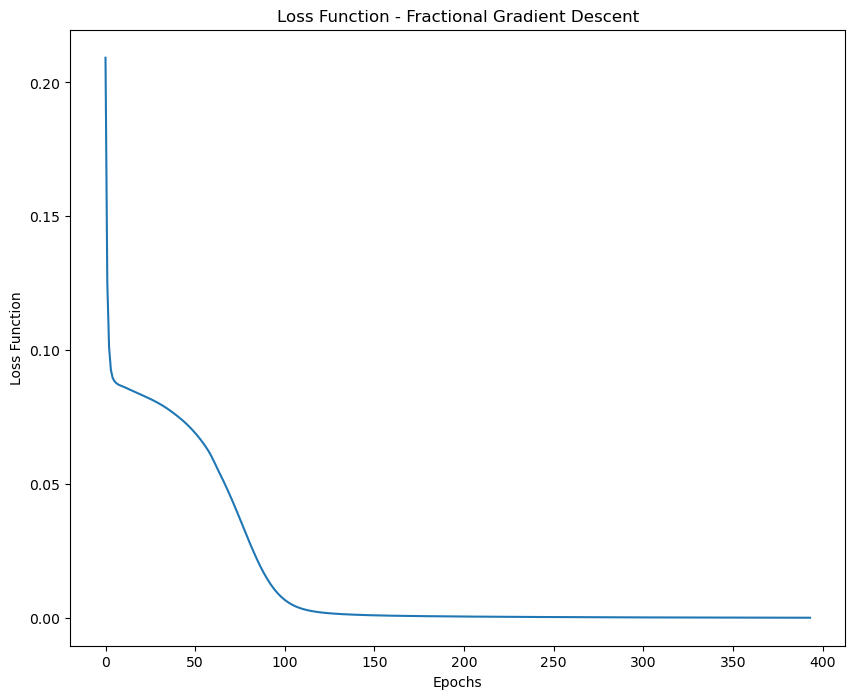

In [11]:
# Plotting the Loss Function
plt.figure(figsize=(10, 8))
plt.plot(loss_list)
plt.title("Loss Function - Fractional Gradient Descent")
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.show;

## Obtaining Values in the Original Scale

In [12]:
# Inverse transformation of the data
# This code transforms the predicted and actual values back to their original scale using the inverse transform method
# of the MinMaxScaler. 
yy = scalerY.inverse_transform(y)
yy_pred = scalerY.inverse_transform(y_pred)
y_obs = np.array(data['C']).reshape(len(data['C']),1)

## Errors plot

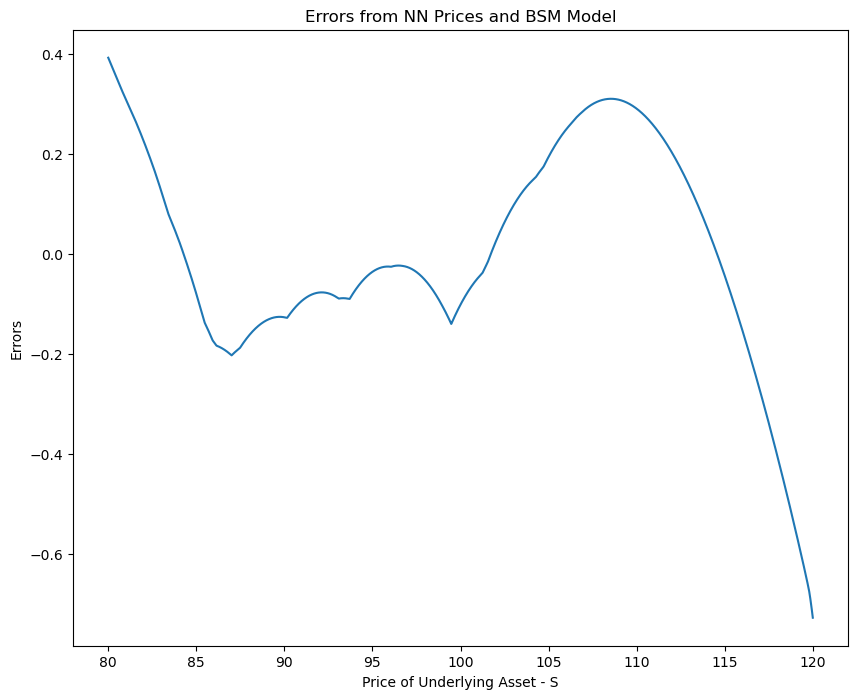

In [13]:
# Error Calculation and Plotting
errores = (yy_pred-yy)
plt.figure(figsize=(10, 8))
plt.plot(S, errores)
plt.title("Errors from NN Prices and BSM Model")
plt.xlabel('Price of Underlying Asset - S')
plt.ylabel('Errors')
plt.show;

## Plotting the results

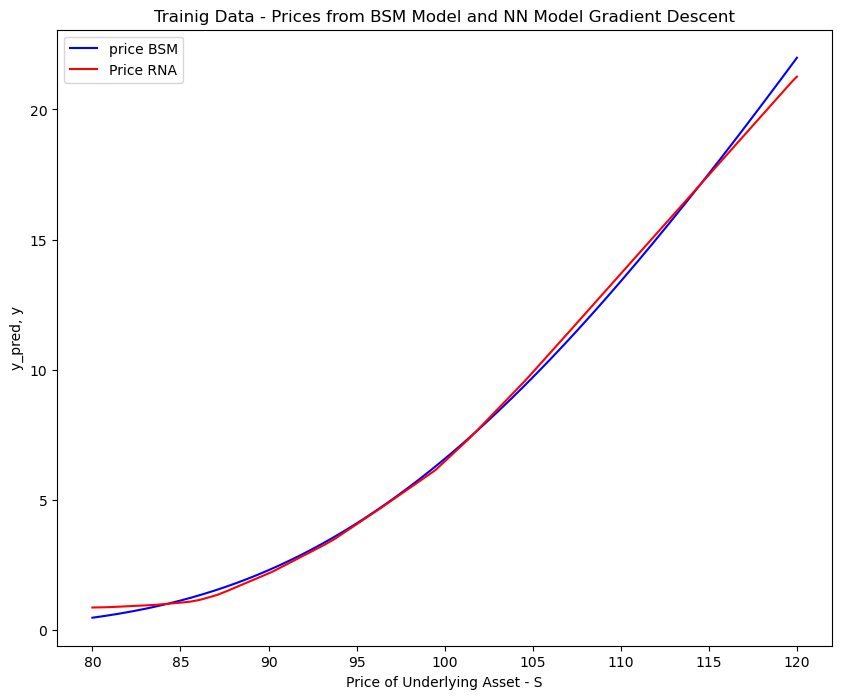

In [14]:
# Gráfica de valores y, y_pred

plt.figure(figsize=(10, 8))
plt.plot(S, yy, c='b', label = "price BSM")
plt.plot(S, yy_pred, c='Red', label = "Price RNA")
plt.title("Trainig Data - Prices from BSM Model and NN Model Gradient Descent")
plt.xlabel('Price of Underlying Asset - S')
plt.ylabel('y_pred, y')
plt.legend()
plt.show;

-----

## Evaluate the NN using new data

In [15]:
# New data for evaluation

L_ = 1000
S_ = np.linspace(60, 140, L_)
K_ =  np.repeat(100, L_)
T_ = np.repeat(0.25, L_)
r_ = np.repeat(0.05, L_)
sigma_ = np.repeat(0.3, L_)

In [16]:
# Call option price
C_ = [BSM_option_price(S_[i], K_[i], T_[i], r_[i], sigma_[i], option = 'call') for i in range(L_)]

In [17]:
# Organize data into a numpy array

values_ = np.array([S_, K_, T_, r_, sigma_, C_])
values_ = values_.T

In [18]:
# Create Data Frame from Numpy Array

columns = ['S', 'K', 'T', 'r', 'sigma', 'C']
data_ = pd.DataFrame(data = values_,  columns = columns) 
data_

,S,K,T,r,sigma,C
0,60.00000,100.0,0.25,0.05,0.3,0.001347
1,60.08008,100.0,0.25,0.05,0.3,0.001395
2,60.16016,100.0,0.25,0.05,0.3,0.001444
3,60.24024,100.0,0.25,0.05,0.3,0.001494
4,60.32032,100.0,0.25,0.05,0.3,0.001546
...,...,...,...,...,...,...
995,139.67968,100.0,0.25,0.05,0.3,40.984177
996,139.75976,100.0,0.25,0.05,0.3,41.063579
997,139.83984,100.0,0.25,0.05,0.3,41.142988
998,139.91992,100.0,0.25,0.05,0.3,41.222404


In [19]:
# Use the trained model to predict new data

xx = np.array(data_[['S', 'K', 'r','sigma','T']])
X_new = scalerX.transform(xx)
dense1.forward(X_new)
activation1_output = activation_funcs.relu(dense1.output)
dense2.forward(activation1_output)
activation2_output = activation_funcs.relu(dense2.output)
dense3.forward(activation2_output)
activation3_output = activation_funcs.relu(dense3.output)
dense4.forward(activation3_output)
y_new = dense4.output
Call_NN = scalerY.inverse_transform(y_new)

In [20]:
C_= np.asarray(C_).reshape(L_,1)

In [21]:
# Errors

error_NN = Call_NN - C_
error_NN.shape

(1000, 1)

## Plot Errors

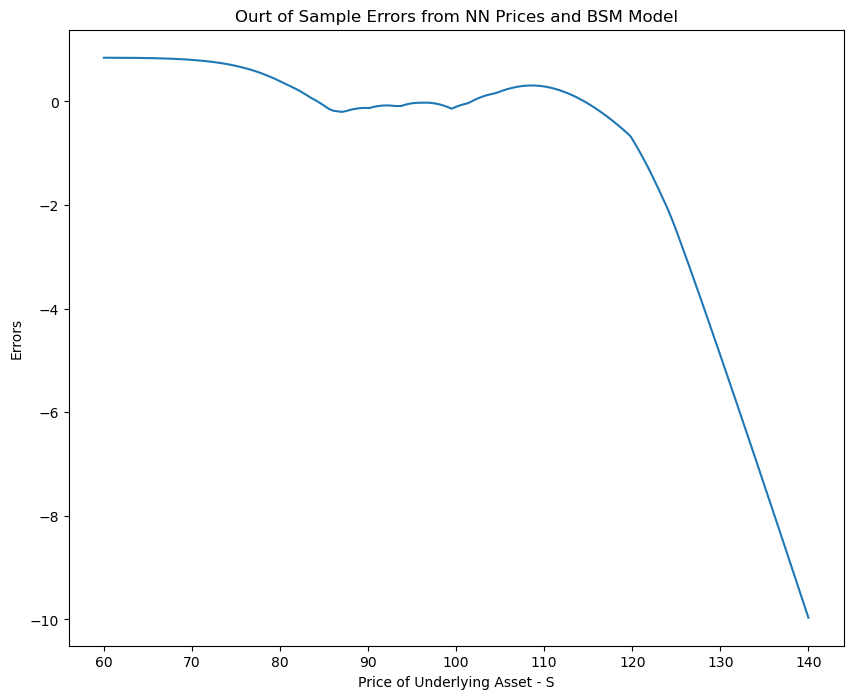

In [22]:
# Plotting the errors for the new data

plt.figure(figsize=(10, 8))
plt.title("Ourt of Sample Errors from NN Prices and BSM Model")
plt.xlabel('Price of Underlying Asset - S')
plt.ylabel('Errors')
plt.plot(S_, error_NN)
plt.show;

## Plot results

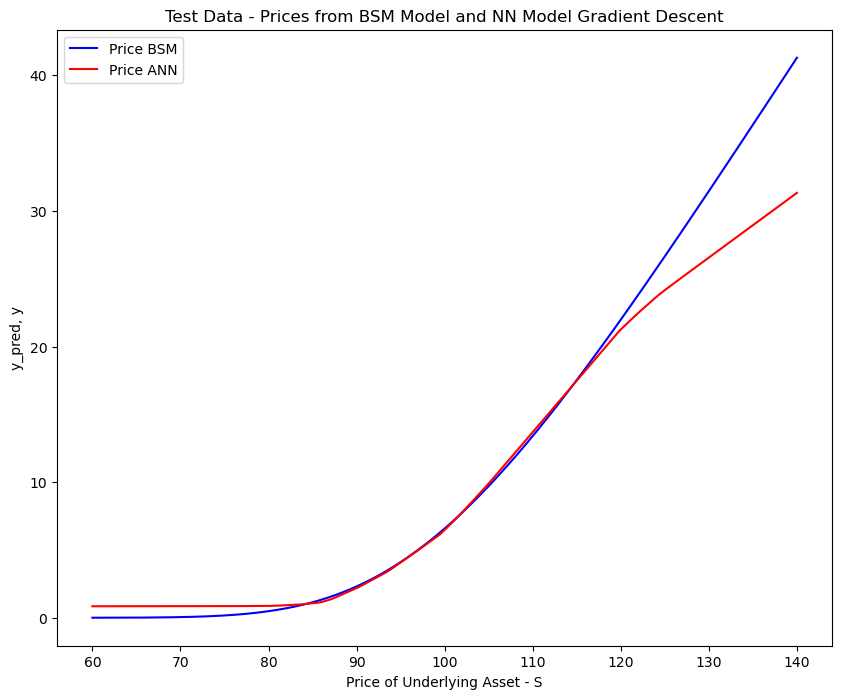

In [23]:
# Plotting results y, y_pred

plt.figure(figsize=(10, 8))
plt.plot(S_, C_, c='b', label = "Price BSM")
plt.plot(S_, Call_NN, c='Red', label = "Price ANN")
plt.title("Test Data - Prices from BSM Model and NN Model Gradient Descent")
plt.xlabel('Price of Underlying Asset - S')
plt.ylabel('y_pred, y')
plt.legend()
plt.show;

In [24]:
# Root Mean Square Error (RMSE) Calculation
# This code calculates the Root Mean Square Error (RMSE) between the predicted option prices
# from the neural network and the actual option prices calculated using the BSM model using new data.
RMSE_NN = np.sqrt(np.sum((C_ - Call_NN)**2))
print(RMSE_NN)

91.62642115557182
